# Reorganizing the Data

In [ ]:
import pandas as pd
import os

servers = ["Server_1", "Server_2", "Server_3", "Server_4", "Server_5", "Server_6"]

days = ["Day_1", "Day_2", "Day_3", "Day_4", "Day_5", "Day_6", "Day_7", "Day_8", "Day_9", "Day_10", "Day_11", "Day_12", "Day_13", "Day_14"]

columns = ["node_load1",
           "node_memory_MemAvailable_bytes",
           "node_network_transmit_bytes_total{device=\"eno1\"}"]

for server in servers:
    for day in days:
        if not os.path.exists(f"{server}_Training_Sets/{day}.xlsx"):
            server_metrics_df = pd.read_csv(f"Training_Sets/Training_Set_{day}/physical_level/{server.lower()}.csv", usecols=columns, sep=";")

            for column in columns:
                server_metrics_df[column] = pd.to_numeric(server_metrics_df[column], errors='coerce')

            server_metrics_df.to_excel(f"{server}_Training_Sets/{day}.xlsx", index=False)

# Dataset Formation


Processando Day_1...
Média: 109.16, Desvio Padrão: 9.55, Valores Únicos: 3372


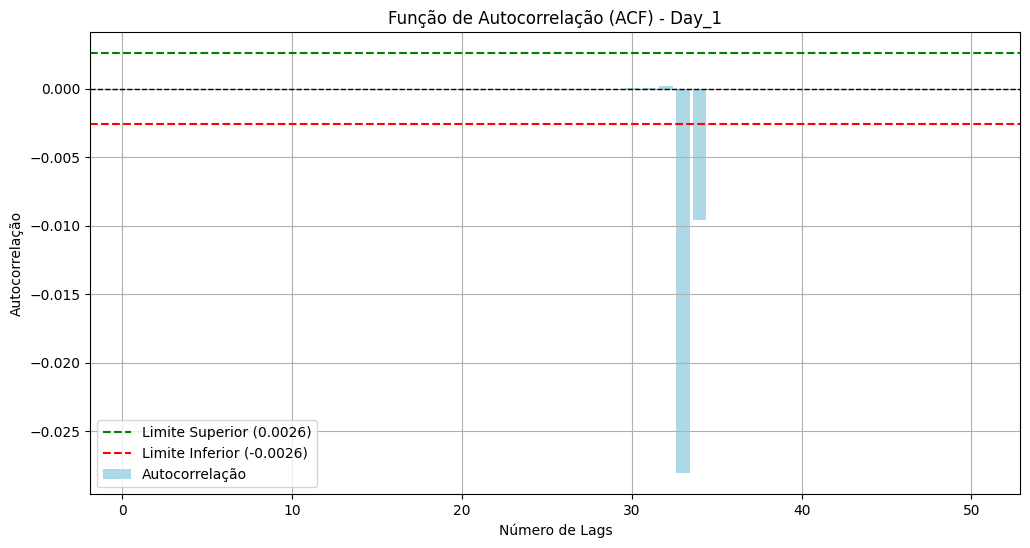

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_1: 40

Processando Day_2...
Média: 109.72, Desvio Padrão: 12.69, Valores Únicos: 2690


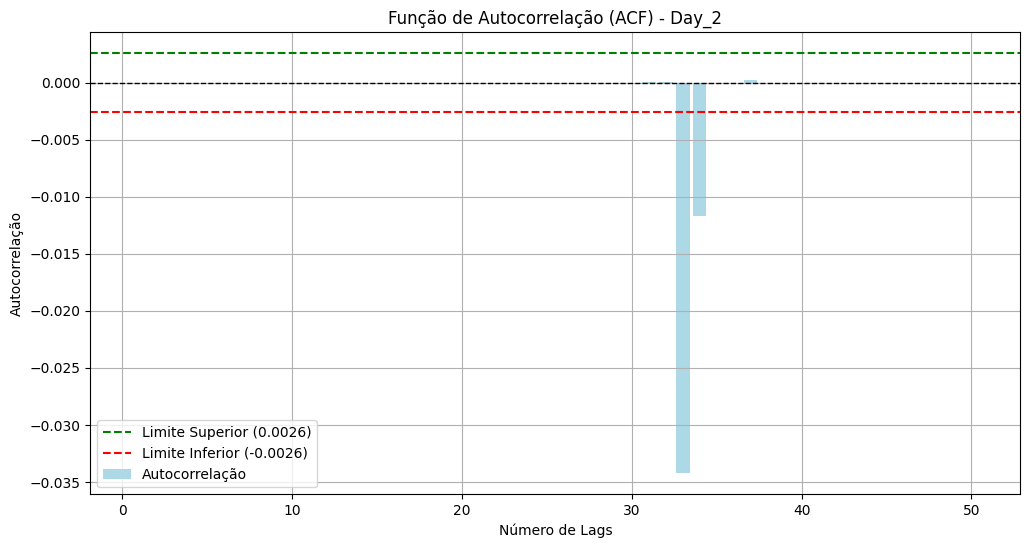

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_2: 40

Processando Day_3...
Média: 95.45, Desvio Padrão: 18.78, Valores Únicos: 4378


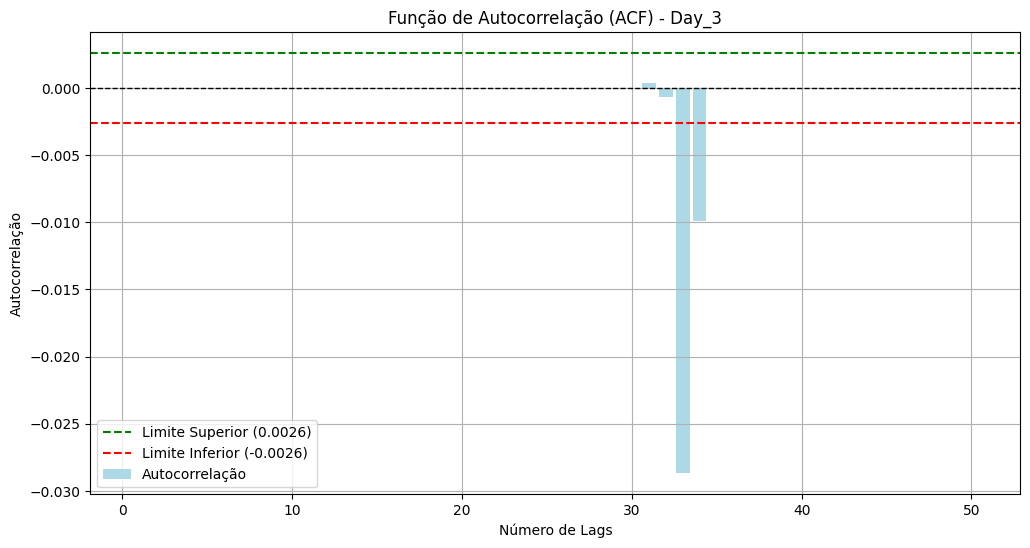

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_3: 40

Processando Day_4...
Média: 103.23, Desvio Padrão: 5.84, Valores Únicos: 2655


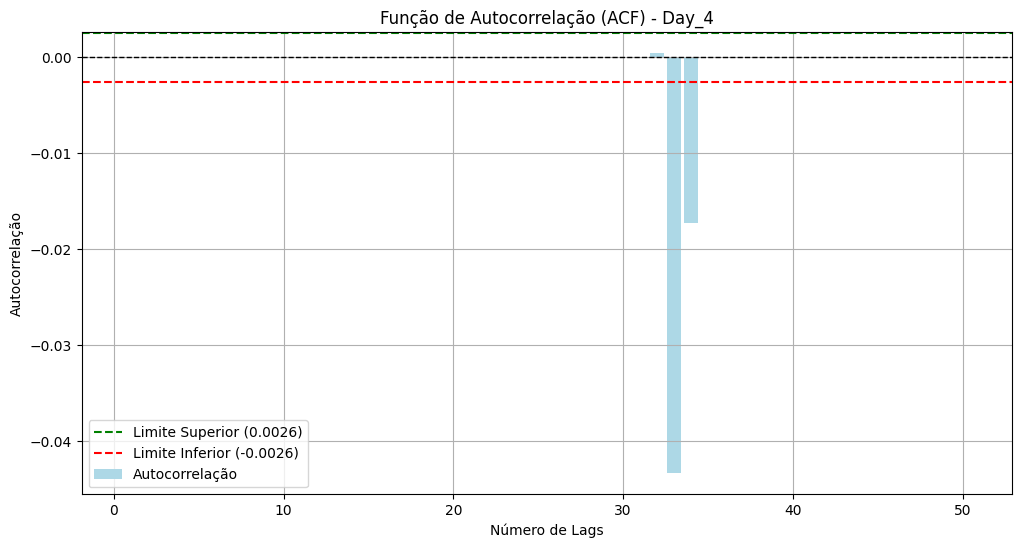

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_4: 40

Processando Day_5...
Média: 104.56, Desvio Padrão: 4.00, Valores Únicos: 2163


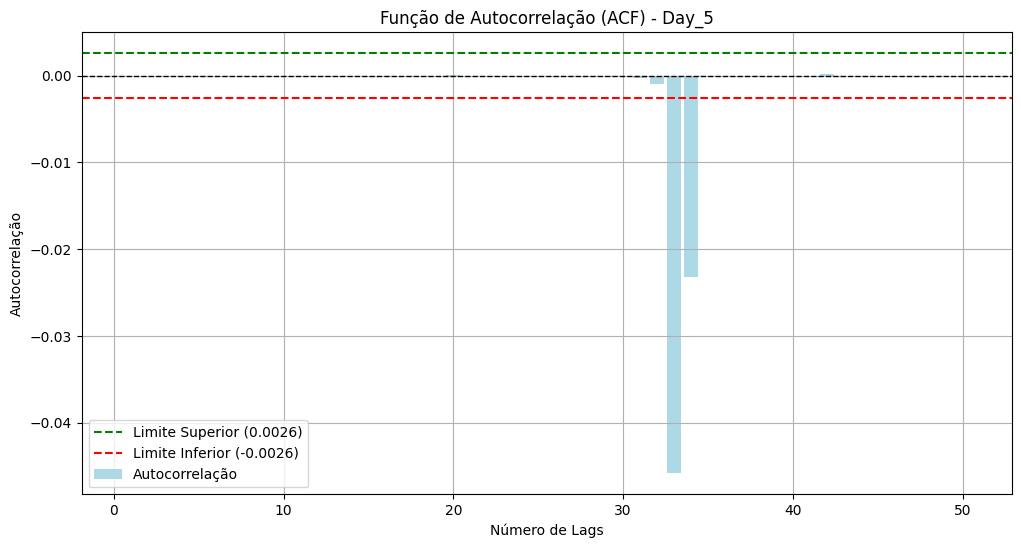

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_5: 40

Processando Day_6...
Média: 103.92, Desvio Padrão: 8.17, Valores Únicos: 3327


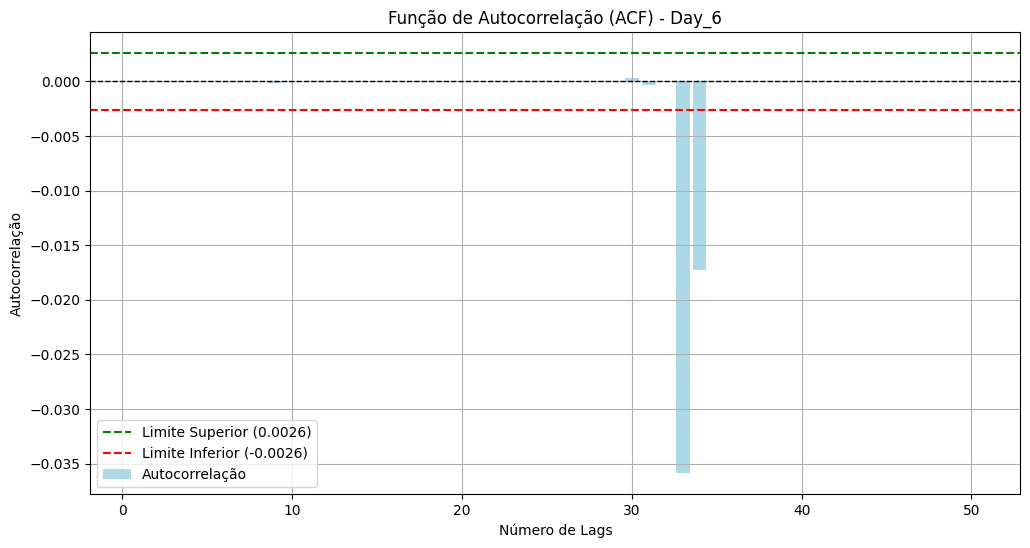

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_6: 40

Processando Day_7...
Média: 5311.54, Desvio Padrão: 3952853.80, Valores Únicos: 3449


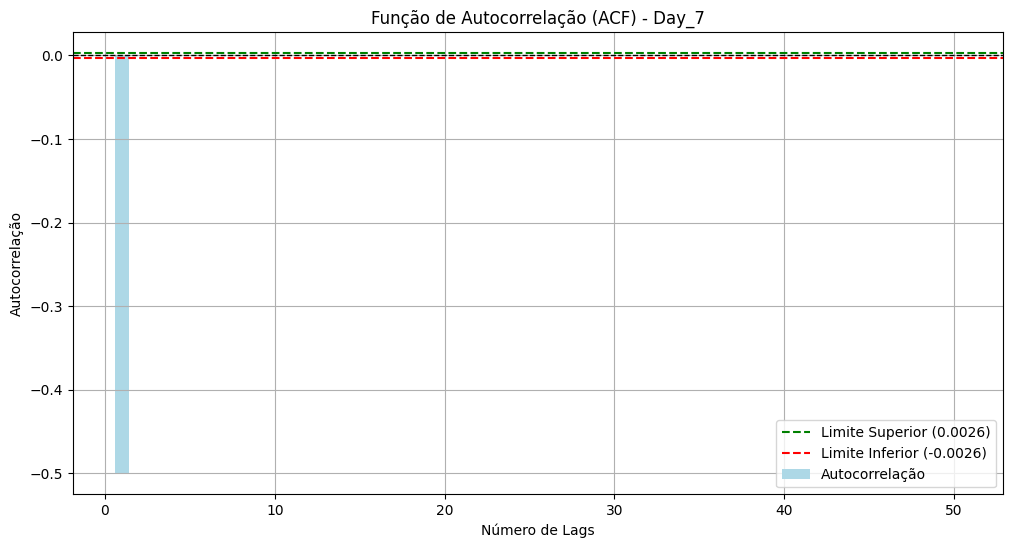

Lags com autocorrelação significativa fora dos limites: 10
Melhor lookback para Day_7: 10

Processando Day_8...
Média: 98.23, Desvio Padrão: 12.42, Valores Únicos: 4062


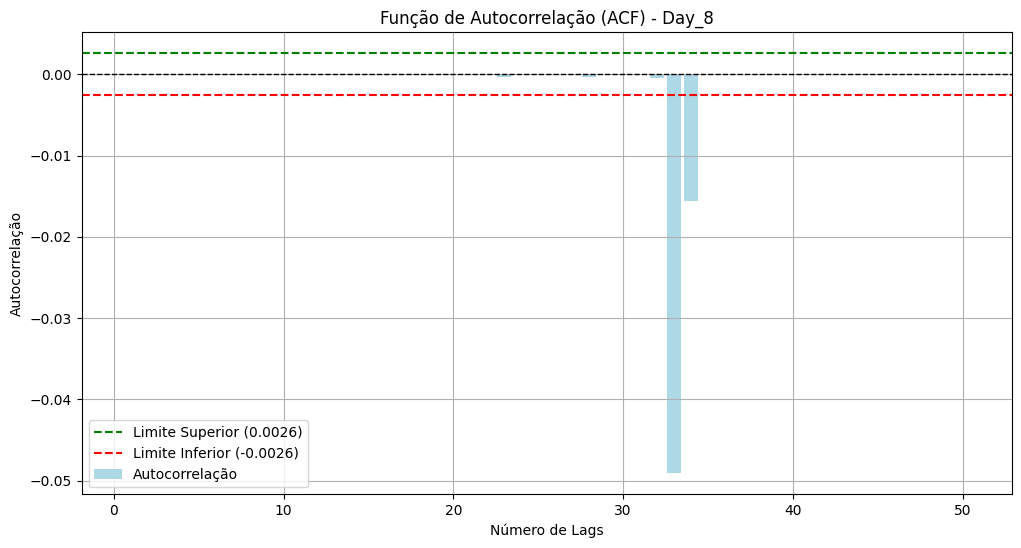

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_8: 40

Processando Day_9...
Média: 97.14, Desvio Padrão: 14.25, Valores Únicos: 4415


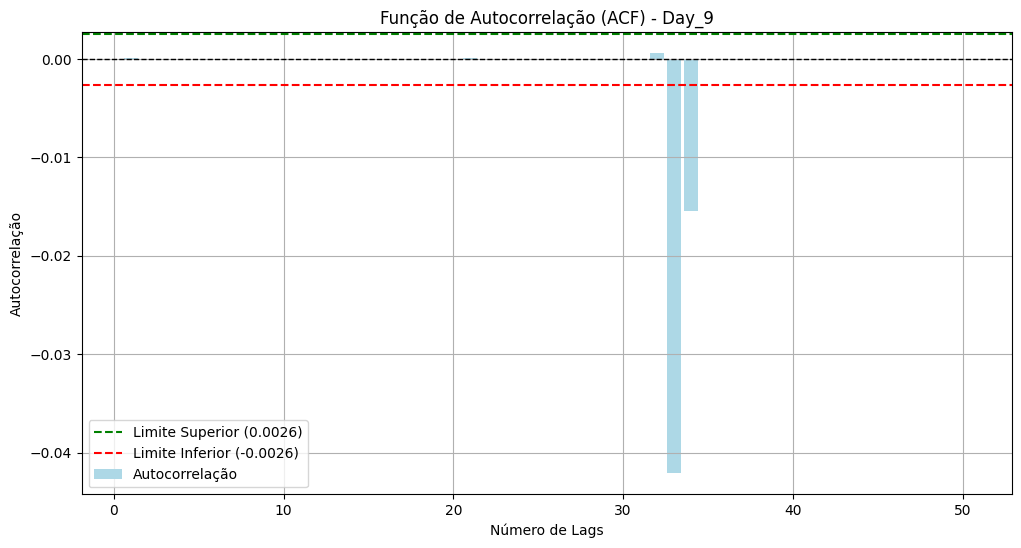

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_9: 40

Processando Day_10...
Média: 95.86, Desvio Padrão: 14.54, Valores Únicos: 4043


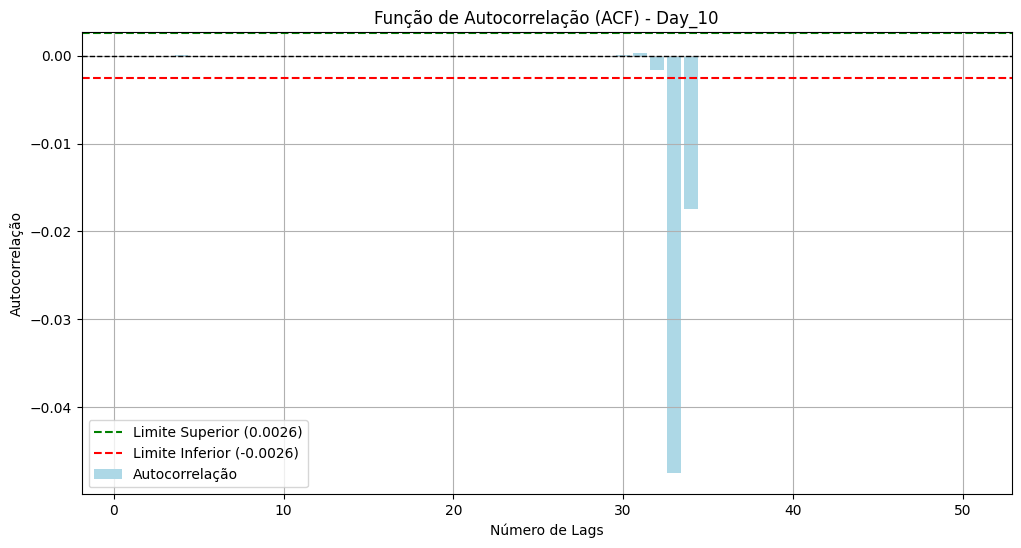

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_10: 40

Processando Day_11...
Média: 84.97, Desvio Padrão: 11.36, Valores Únicos: 4003


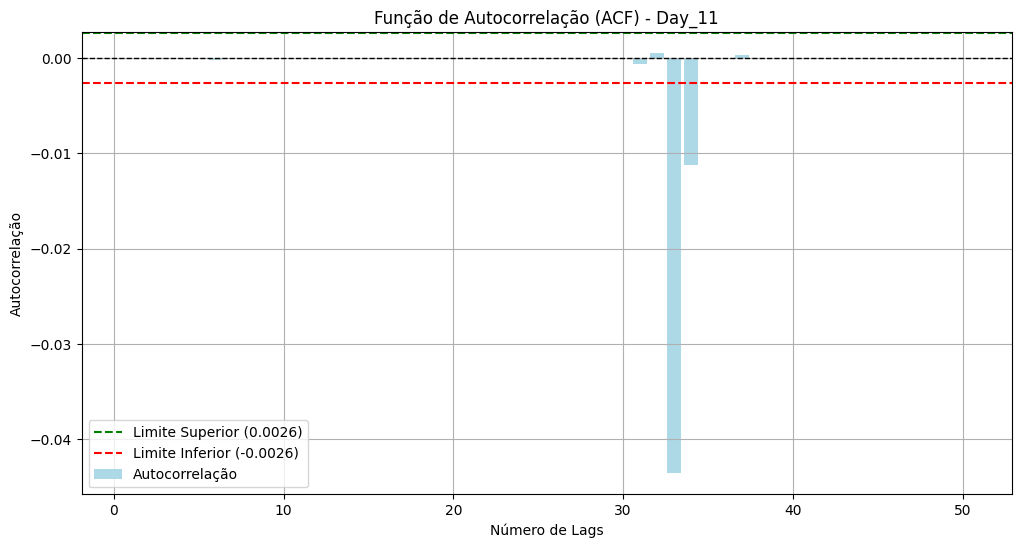

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_11: 40

Processando Day_12...
Média: 79.02, Desvio Padrão: 5.90, Valores Únicos: 2656


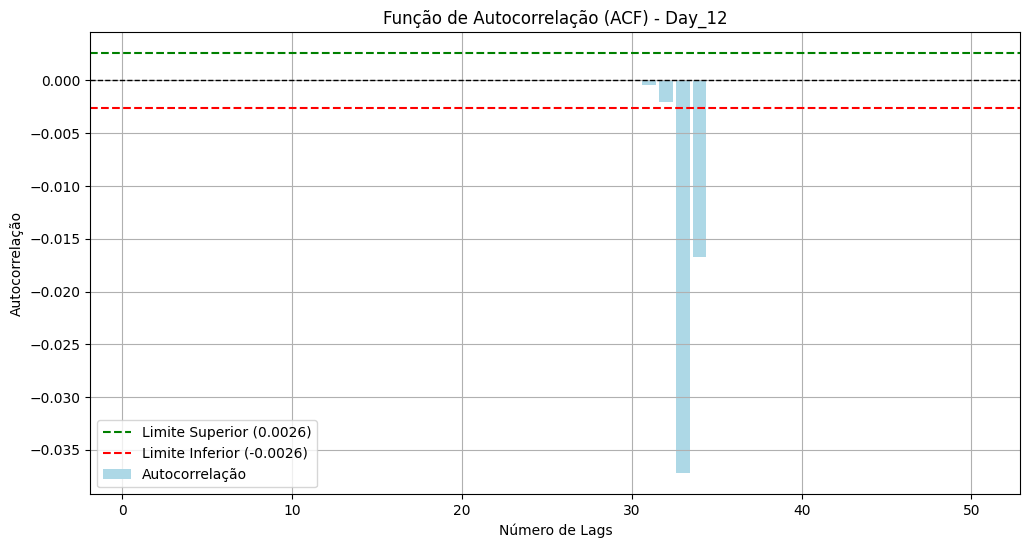

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_12: 40

Processando Day_13...
Média: 75.98, Desvio Padrão: 3.64, Valores Únicos: 1819


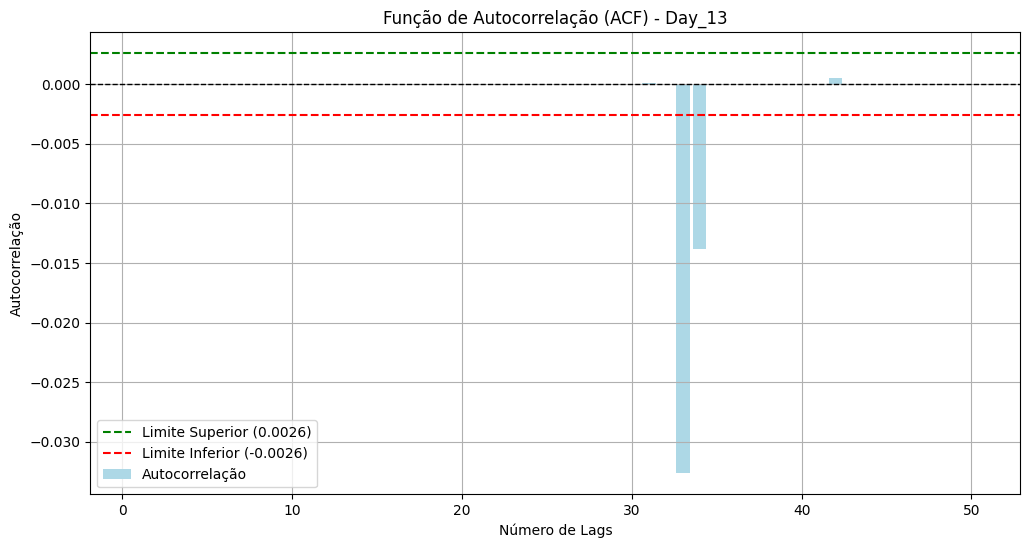

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_13: 40

Processando Day_14...
Média: 75.40, Desvio Padrão: 2.95, Valores Únicos: 1578


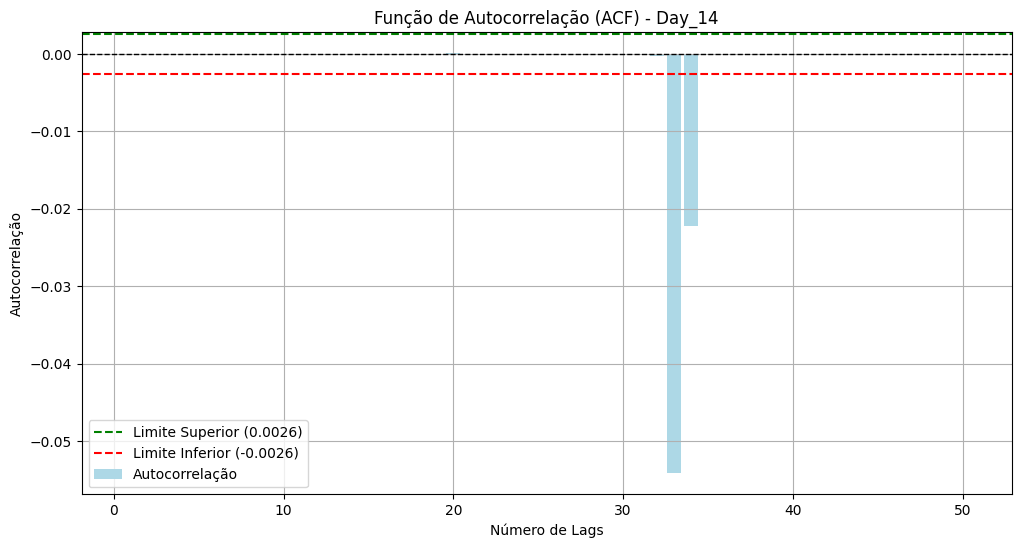

Lags com autocorrelação significativa fora dos limites: 40
Melhor lookback para Day_14: 40

--- Resultado Final ---
Média dos melhores lookbacks para todos os dias: 37


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Lista de dias
days = ["Day_1", "Day_2", "Day_3", "Day_4", "Day_5", "Day_6", "Day_7", "Day_8", 
        "Day_9", "Day_10", "Day_11", "Day_12", "Day_13", "Day_14"]

best_lookbacks = []  # Lista para armazenar o melhor lookback de cada dia

for day in days:
    print(f"\nProcessando {day}...")

    # Carregar o dataset
    server_metrics_df = pd.read_excel(f"Server_1_Training_Sets/{day}.xlsx")

    # Selecionar o atributo
    dataset = pd.Series(server_metrics_df["node_load1"]).dropna().reset_index(drop=True)

    # Estatísticas Básicas
    print(f"Média: {dataset.mean():.2f}, Desvio Padrão: {dataset.std():.2f}, Valores Únicos: {len(np.unique(dataset))}")

    # Transformação da Série para Remover Tendência (Diferença de Primeira Ordem)
    diff_dataset = dataset.diff().dropna()

    # Definir a target deslocada em 400 amostras à frente
    step = 400  # Previsão para 400 amostras no futuro
    y_target = diff_dataset.shift(-step).dropna()

    # Ajustar diff_dataset para ter o mesmo tamanho da target
    diff_dataset = diff_dataset.iloc[:len(y_target)]

    # Calcular a função de autocorrelação (ACF)
    lookback_max = 50  # Máximo de lags a serem avaliados
    autocorr_values = [
        diff_dataset.autocorr(lag=i) for i in range(1, lookback_max + 1)
    ]

    # Definir limites de significância
    n = len(diff_dataset)
    limite_inferior = -1.96 / np.sqrt(n)
    limite_superior = 1.96 / np.sqrt(n)

    # Plotar a autocorrelação
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, lookback_max + 1), autocorr_values, color="lightblue", label="Autocorrelação")
    plt.axhline(y=limite_superior, color='green', linestyle='--', linewidth=1.5, label=f"Limite Superior ({limite_superior:.4f})")
    plt.axhline(y=limite_inferior, color='red', linestyle='--', linewidth=1.5, label=f"Limite Inferior ({limite_inferior:.4f})")
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.title(f"Função de Autocorrelação (ACF) - {day}")
    plt.xlabel("Número de Lags")
    plt.ylabel("Autocorrelação")
    plt.legend()
    plt.grid()
    plt.show()

    # Identificar o melhor lookback com base nos lags significativos
    lookback_scores = []
    for lookback in range(10, lookback_max + 1, 10):  # Avaliar de 10 em 10 lags
        significant_count = sum(
            corr > limite_superior or corr < limite_inferior for corr in autocorr_values[:lookback]
        )
        lookback_scores.append((lookback, significant_count))

    # Selecionar o lookback com mais lags significativos
    # Critério: Maior quantidade de lags significativos com o menor lookback possível
    best_lookback = max(lookback_scores, key=lambda x: x[1])[0]
    best_lookbacks.append(best_lookback)

    print(f"Lags com autocorrelação significativa fora dos limites: {best_lookback}")
    print(f"Melhor lookback para {day}: {best_lookback}")

# Calcular a média dos melhores lookbacks
final_lookback = int(np.mean(best_lookbacks))
print("\n--- Resultado Final ---")
print(f"Média dos melhores lookbacks para todos os dias: {final_lookback}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

from tqdm import tqdm
import numpy as np
import pandas as pd

def random_sample_selection(time_series_df, num_samples):
    """
    Seleciona aleatoriamente 'num_samples' amostras do DataFrame.
    
    Args:
        time_series_df (pd.DataFrame): DataFrame com features e target.
        num_samples (int): Número de amostras desejadas.

    Returns:
        pd.DataFrame: DataFrame contendo as amostras selecionadas.
    """
    # Remover linhas com NaNs para evitar problemas
    time_series_df = time_series_df.dropna()

    # Garantir que o número de amostras não exceda o total disponível
    num_samples_to_select = min(num_samples, len(time_series_df))

    # Selecionar amostras aleatórias
    selected_df = time_series_df.sample(n=num_samples_to_select, random_state=42)

    print(f"Amostras selecionadas aleatoriamente: {num_samples_to_select}")
    return selected_df

days = ["Day_1", "Day_2", "Day_3", "Day_4", "Day_5", "Day_6", "Day_7", "Day_8", 
        "Day_9", "Day_10", "Day_11", "Day_12", "Day_13", "Day_14"]

global_representative_df = pd.DataFrame()

for day in days:
    print(f"\nProcessando {day}...")

    server_metrics_df = pd.read_excel(f"Server_1_Training_Sets/{day}.xlsx")

    step = 400  # Previsão 400 amostras à frente
    lookback = 40

    dataset = np.array(server_metrics_df["node_load1"])
    #dataset = np.array(server_metrics_df["node_memory_MemAvailable_bytes"])
    
    # No caso do atributo de rede é necessário derivar.
    #dataset = np.array(server_metrics_df["node_network_transmit_bytes_total{device=\"eno1\"}"])
    #dataset = pd.Series([dataset[idx + 1] - dataset[idx] for idx in range(len(dataset) - 1)])
    #dataset = dataset.drop_duplicates()
    #dataset = dataset[dataset < dataset.mean() + 4 * dataset.std()]
    #dataset = dataset.reset_index(drop=True)

    # Construir as features (X) e o target (y)
    X, y = [], []
    for i in range(len(dataset) - (lookback + step)):
        feature = dataset[i:i + lookback]
        target = dataset[i + lookback + step]
        X.append(feature)
        y.append(target)

    time_series_df = pd.DataFrame(
        data=[list(X_v) + [y_v] for X_v, y_v in zip(X, y)],
        columns=[f"X{idx+1}" for idx in range(lookback)] + ["y"]
    )

    num_samples = 10000  # Número de amostras desejadas

    # Chamar a função de seleção aleatória
    representative_df = random_sample_selection(time_series_df, num_samples)

    global_representative_df = pd.concat([global_representative_df, representative_df], ignore_index=True)

print("\nDataset Representativo Final:")
print(global_representative_df)

In [ ]:
global_representative_df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,y
count,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,...,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05,1.400000e+05
mean,-2.098120e+07,1.178195e+06,1.178307e+06,-2.100859e+07,1.178422e+06,1.178359e+06,-2.098123e+07,1.178118e+06,1.178420e+06,-2.100854e+07,...,1.178165e+06,1.178682e+06,1.178046e+06,1.178160e+06,1.178420e+06,-2.098165e+07,1.178465e+06,1.178087e+06,-2.100854e+07,-2.098166e+07
std,8.291482e+09,1.093130e+05,1.094105e+05,8.301564e+09,1.093664e+05,1.093942e+05,8.291482e+09,1.097017e+05,1.094444e+05,8.301564e+09,...,1.095047e+05,1.096356e+05,1.095309e+05,1.092814e+05,1.095741e+05,8.291482e+09,1.093052e+05,1.093432e+05,8.301564e+09,8.291482e+09
min,-3.102387e+12,1.852800e+04,6.898940e+05,-3.106160e+12,6.156820e+05,7.433770e+05,-3.102387e+12,3.490600e+05,6.156820e+05,-3.106160e+12,...,3.490600e+05,6.182920e+05,6.156820e+05,7.020490e+05,3.490600e+05,-3.102387e+12,5.340900e+05,7.433770e+05,-3.106160e+12,-3.102387e+12
25%,1.101372e+06,1.100528e+06,1.100578e+06,1.100201e+06,1.100582e+06,1.100738e+06,1.100632e+06,1.100488e+06,1.100568e+06,1.100774e+06,...,1.100198e+06,1.101362e+06,1.099989e+06,1.099962e+06,1.100756e+06,1.100586e+06,1.100590e+06,1.100448e+06,1.100878e+06,1.100473e+06
50%,1.184650e+06,1.184070e+06,1.184352e+06,1.184356e+06,1.184468e+06,1.184212e+06,1.184500e+06,1.184288e+06,1.184400e+06,1.184232e+06,...,1.183774e+06,1.184568e+06,1.183862e+06,1.184071e+06,1.184842e+06,1.184066e+06,1.184476e+06,1.184038e+06,1.183985e+06,1.184410e+06
75%,1.247501e+06,1.246799e+06,1.246984e+06,1.247284e+06,1.247129e+06,1.247044e+06,1.247566e+06,1.246572e+06,1.247268e+06,1.246950e+06,...,1.247166e+06,1.247278e+06,1.246999e+06,1.246910e+06,1.247046e+06,1.247110e+06,1.247251e+06,1.246797e+06,1.247053e+06,1.247253e+06
max,1.551435e+06,1.519929e+06,1.551435e+06,1.514752e+06,1.630024e+06,1.533085e+06,3.547133e+06,4.087080e+06,1.520898e+06,1.519929e+06,...,3.547133e+06,4.087080e+06,1.509221e+06,1.551435e+06,1.502861e+06,1.546694e+06,1.526074e+06,1.546694e+06,1.527762e+06,1.526074e+06


In [9]:
global_representative_df.to_excel("Server_1_Training_Sets/node_network_transmit_bytes_total.xlsx", index=False)

# Dataset Treatment

In [10]:
import pandas as pd
import numpy as np

# Carregar o dataset
#dataset = pd.read_excel("Server_1_Training_Sets/node_load1.xlsx")
#dataset = pd.read_excel("Server_1_Training_Sets/node_memory_MemAvailable_bytes.xlsx")
dataset = pd.read_excel("Server_1_Training_Sets/node_network_transmit_bytes_total.xlsx")

# Exibir as primeiras linhas para visualizar a estrutura do dataset
print("Estrutura do dataset:")
print(dataset.head())

# Inicializar dicionários para armazenar os valores máximos de cada coluna dentro de 3 desvios padrões
max_values = {}

# Iterar sobre as colunas de features X1 até X40
for col in [f"X{i}" for i in range(1, 41)]:
    # Calcular a média e o desvio padrão para a coluna atual
    mean_col = dataset[col].mean()
    std_col = dataset[col].std()
    
    # Definir os limites de 3 desvios padrões
    lower_limit = mean_col - 3 * std_col
    upper_limit = mean_col + 3 * std_col
    
    # Filtrar os dados dentro dos limites e encontrar o valor máximo
    max_value = dataset[(dataset[col] >= lower_limit) & (dataset[col] <= upper_limit)][col].max()
    max_values[col] = max_value

# Fazer o mesmo para a coluna 'y'
mean_y = dataset['y'].mean()
std_y = dataset['y'].std()
lower_limit_y = mean_y - 3 * std_y
upper_limit_y = mean_y + 3 * std_y
max_y = dataset[(dataset['y'] >= lower_limit_y) & (dataset['y'] <= upper_limit_y)]['y'].max()
max_values['y'] = max_y

# Exibir os valores máximos encontrados
for key, value in max_values.items():
    print(f"Maior valor de {key} dentro de 3 desvios padrões: {value}")

# Normalizar o dataset usando os valores máximos encontrados
normalized_dataset = dataset.copy()
for col in max_values.keys():
    normalized_dataset[col] = normalized_dataset[col] / max_values[col]

# CPU
#...

# RAM
#normalized_dataset = 1 - normalized_dataset
#normalized_dataset[normalized_dataset < 0] = 0

# Network
normalized_dataset[normalized_dataset < 0] = 0

# Exibir as primeiras linhas do dataset normalizado
print("\nDataset Normalizado:")
print(normalized_dataset.head())

Estrutura do dataset:
        X1       X2       X3       X4       X5       X6       X7       X8  \
0  1070584  1172793  1198158  1200314  1188662  1059310  1191608  1050482   
1  1192787  1168678  1048868  1174879  1067027  1191792  1027350  1209691   
2  1136651  1171359  1013120  1010551  1158398  1140730  1006933  1164371   
3   864032  1167339  1028596  1150681  1062325  1113942  1172155  1181506   
4  1164688  1006637  1162728  1013508  1164049  1115380  1066410  1005607   

        X9      X10  ...      X32      X33      X34      X35      X36  \
0  1218293  1051218  ...  1018043  1198944  1039540  1181757  1197282   
1  1160594  1170632  ...  1204726  1101360  1052936  1175882  1017845   
2  1009891  1155660  ...  1104504  1165761  1159217  1150303  1019021   
3  1007999  1096128  ...  1159109  1156302  1159142  1005864  1154929   
4  1168434  1038089  ...  1152407  1007418  1006685  1149358  1158724   

       X37      X38      X39      X40        y  
0  1120165  1190949  115236

In [11]:
import json

#with open("Server_1_Training_Sets/jsons/max_cpu.json", "w") as f:
#    json.dump(max_values, f)
    
# Para valores grandes
max_values_converted = {key: int(value) if isinstance(value, np.integer) else float(value)
                        for key, value in max_values.items()}

# Salvar o dicionário convertido em um arquivo JSON
with open("Server_1_Training_Sets/jsons/max_network.json", "w") as f:
    json.dump(max_values_converted, f, indent=4)

In [12]:
normalized_dataset.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,y
count,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,...,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000
mean,0.759758,0.791138,0.785927,0.777861,0.784568,0.787760,0.332290,0.783062,0.791289,0.775245,...,0.783948,0.791465,0.783014,0.795697,0.784118,0.761792,0.783292,0.785781,0.771267,0.772082
std,0.070557,0.073402,0.072977,0.072279,0.072814,0.073133,0.030890,0.072916,0.073490,0.071953,...,0.072864,0.073618,0.072802,0.073806,0.072910,0.070724,0.072652,0.072932,0.071631,0.071722
min,0.000000,0.012441,0.460157,0.000000,0.409908,0.496964,0.000000,0.232010,0.413420,0.000000,...,0.232264,0.415173,0.409226,0.474145,0.232264,0.000000,0.354995,0.495830,0.000000,0.000000
25%,0.709905,0.738986,0.734082,0.726324,0.732744,0.735868,0.310288,0.731463,0.739013,0.724227,...,0.732069,0.739546,0.731131,0.742884,0.732440,0.711573,0.731531,0.733995,0.720582,0.721114
50%,0.763583,0.795083,0.789960,0.781881,0.788593,0.791672,0.333932,0.787163,0.795304,0.779136,...,0.787680,0.795418,0.786880,0.799689,0.788391,0.765547,0.787288,0.789750,0.774980,0.776116
75%,0.804095,0.837204,0.831735,0.823425,0.830312,0.833677,0.351711,0.828561,0.837520,0.820400,...,0.829861,0.837526,0.828845,0.842129,0.829781,0.806307,0.829013,0.831610,0.816261,0.817295
max,1.000000,1.020606,1.034803,1.000000,1.085235,1.024902,1.000000,2.716567,1.021257,1.000000,...,2.360254,2.744405,1.003137,1.047797,1.000000,1.000000,1.014338,1.031640,1.000000,1.000000


In [13]:
normalized_dataset.to_excel("Server_1_Training_Sets/network_usage.xlsx", index=False)